Using the same data as are in the expanded version of the 02_optimization_notebook.ipynb, we will conduct logistic regression. Following discussion with Prof. Davis on 2/17, we realized that linear regression was a poor choice as we are working with a binary classification problem (match or non-match). A more appropriate option is logistic regression, where a logistic/sigmoid function applied to a linear combination of input values, allowing prediction of a binary outcome. An overview comparing these methods is as follows.

## 0. Optimization Problem Formulation

### (previous) Linear Regression

**Features:** Similarity vectors $$\mathbf{s} = [s_1, s_2, s_3, s_4, s_5]$$ represent the calculated similarity scores for 5 musical features (key, time signature, average pitch, pitch range, note density), based on feature similarity functions (see 01_data_prep_notebook.ipynb)

**Labels:** 1: matching, 0: non-matching

**Loss (as optimization problem):**
Minimize
$$
L(\mathbf{w}) = \sum_{(i, j) \in \text{training pairs}} (\text{label}_{ij} - \mathbf{w}^T\mathbf{s}_{ij})^2
$$
Subject to
1. $\sum_{k=1}^{5} w_k = 1$ (weights sum to 1)
2. $w_k \geq 0$ for all $k \in \{1,2,3,4,5\}$ (non-negative weights)

For reference, the gradient with respect to w is as follows:
$$\nabla L(\mathbf{w}) = -2 \sum_{(i,j)} \left( \text{label}_{ij} - \mathbf{w}^T \mathbf{s}_{ij} \right) \mathbf{s}_{ij}$$

**Goal:** Learn a weight vector of $$\mathbf{w} = [w_1, w_2, w_3, w_4, w_5]$$ that is optimized for threshold-based classification that will predict as follows
$$\begin{cases}
    1, & \mathbf{w}^Ts > 0.5
    \\ 0, & \mathbf{w}^Ts \leq 0.5
\end{cases}$$

### (revised) Logistic Regression

**Features:** same

**Labels:** same

**Loss (as optimization problem):**
Negative log-likelihood loss (Binary Cross-Entropy Loss). This is evidently also a convex loss.

Minimize
$$
L(\mathbf{w}) = -\sum_{(i, j) \in \text{training pairs}} \text{label}_{ij} \cdot \log{(\sigma(\mathbf{w}^T\mathbf{s}_{ij})) + (1 - \text{label}_{ij}}) \cdot \log{(1 - \sigma(\mathbf{w}^T\mathbf{s}_{ij}))}
$$
Subject to:
1. $\sum_{k=1}^{5} w_k = 1$ (weights sum to 1)
2. $w_k \geq 0$ for all $k \in \{1,2,3,4,5\}$ (non-negative weights)

For reference, the gradient with respect to $w$ is as follows:
$$\nabla L(\mathbf{w}) = \sum_{(i,j)} (\sigma(\mathbf{w}^Ts_{ij}) - \text{label}_{ij}) \cdot \mathbf{s}_{ij}$$

**Goal:** Learn a weight vector of $$\mathbf{w} = [w_1, w_2, w_3, w_4, w_5]$$ that is optimized for classification based on the following where $\mathbf{1}$ is the indicator function. The behavior of the sigmoid is that it converts values from $-\infty$ to $\infty$ into probabilities and is centered around 0 so this works.
$$\mathbf{1}(\mathbf{w}^T\mathbf{s}_{ij} \geq 0) = \begin{cases}
1, &\mathbf{w}^T\mathbf{s}_{ij} \geq 0
\\ 0, & o.w.
\end{cases}$$

## Setup and Data Loading
Below we will copy and paste over relevant items from the previous version 02_optimization_notebook.ipynb, omitting some nonnecessaries

In [116]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.optimize import minimize, LinearConstraint, Bounds
import cvxpy as cp
from sklearn.metrics import confusion_matrix
import json
from pathlib import Path
import time

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(precision=4, suppress=True)

In [2]:
# Datasets loading and info display
# Define data paths
data_dir = Path('../data')
train_path = data_dir / 'train_pairs.csv'
test_path = data_dir / 'test_pairs.csv'
features_path = data_dir / 'sheet_music_features.csv'
metadata_path = data_dir / 'data_metadata.json'

# Load the datasets
print("Loading data files...")
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
features_data = pd.read_csv(features_path)

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print("✓ All data files loaded successfully!")

# Print metadata
print("="*80)
print("DATASET METADATA")
print("="*80)
print(json.dumps(metadata, indent=2))
print("="*80)

Loading data files...
✓ All data files loaded successfully!
DATASET METADATA
{
  "dataset_info": {
    "total_composers": 3,
    "total_pieces": 14,
    "total_pages": 56,
    "measures_per_page": 8,
    "pages_per_piece": 4,
    "composers": {
      "bach": {
        "name": "Bach",
        "era": "Baroque",
        "pieces": 6,
        "pages": 24
      },
      "mozart": {
        "name": "Mozart",
        "era": "Classical",
        "pieces": 3,
        "pages": 12
      },
      "beethoven": {
        "name": "Beethoven",
        "era": "Classical/Romantic",
        "pieces": 5,
        "pages": 20
      }
    },
    "piece_ids": [
      "bach_bwv17.7",
      "bach_bwv248.42-4",
      "bach_bwv276",
      "bach_bwv29.8",
      "bach_bwv320",
      "bach_bwv328",
      "mozart_movement1",
      "mozart_movement2",
      "mozart_movement3",
      "beethoven_opus132",
      "beethoven_opus133",
      "beethoven_movement1",
      "beethoven_movement2",
      "beethoven_movement3"
    

In [3]:
# Display pairs created
# Verify label distribution
print("="*80)
print("LABEL DISTRIBUTION")
print("="*80)

print("Training data:")
train_label_counts = train_data['label'].value_counts().sort_index()
print(f"  Non-matching pairs (label=0): {train_label_counts[0]:,} ({train_label_counts[0]/len(train_data)*100:.1f}%)")
print(f"  Matching pairs (label=1):     {train_label_counts[1]:,} ({train_label_counts[1]/len(train_data)*100:.1f}%)")
print(f"  Total: {len(train_data):,}")
print()

print("Test data:")
test_label_counts = test_data['label'].value_counts().sort_index()
print(f"  Non-matching pairs (label=0): {test_label_counts[0]:,} ({test_label_counts[0]/len(test_data)*100:.1f}%)")
print(f"  Matching pairs (label=1):     {test_label_counts[1]:,} ({test_label_counts[1]/len(test_data)*100:.1f}%)")
print(f"  Total: {len(test_data):,}")
print("="*80)
print()

# Analyze pair types by composer combinations
print("="*80)
print("PAIR TYPES BY COMPOSER COMBINATIONS")
print("="*80)

print("\nTraining data:")
for pair_type in ['matching', 'hard_negative', 'easy_negative']:
    subset = train_data[train_data['pair_type'] == pair_type]
    if len(subset) > 0:
        print(f"\n{pair_type.upper()}:")
        composer_combos = subset.groupby(['composer_1', 'composer_2']).size().sort_values(ascending=False)
        for (comp1, comp2), count in composer_combos.items():
            print(f"  {comp1}-{comp2}: {count:,}")

print("\n" + "="*80)
print("\nTest data:")
for pair_type in ['matching', 'hard_negative', 'easy_negative']:
    subset = test_data[test_data['pair_type'] == pair_type]
    if len(subset) > 0:
        print(f"\n{pair_type.upper()}:")
        composer_combos = subset.groupby(['composer_1', 'composer_2']).size().sort_values(ascending=False)
        for (comp1, comp2), count in composer_combos.items():
            print(f"  {comp1}-{comp2}: {count:,}")

print("\n" + "="*80)

# Analyze pair type distribution
print("PAIR TYPE DISTRIBUTION")
print("="*80)

print("\nTraining data:")
train_pair_counts = train_data['pair_type'].value_counts()
for pair_type in ['matching', 'hard_negative', 'easy_negative']:
    if pair_type in train_pair_counts:
        count = train_pair_counts[pair_type]
        pct = count / len(train_data) * 100
        print(f"  {pair_type:15s}: {count:,} ({pct:.1f}%)")
print(f"  {'Total':15s}: {len(train_data):,}")

print("\nTest data:")
test_pair_counts = test_data['pair_type'].value_counts()
for pair_type in ['matching', 'hard_negative', 'easy_negative']:
    if pair_type in test_pair_counts:
        count = test_pair_counts[pair_type]
        pct = count / len(test_data) * 100
        print(f"  {pair_type:15s}: {count:,} ({pct:.1f}%)")
print(f"  {'Total':15s}: {len(test_data):,}")

LABEL DISTRIBUTION
Training data:
  Non-matching pairs (label=0): 21 (60.0%)
  Matching pairs (label=1):     14 (40.0%)
  Total: 35

Test data:
  Non-matching pairs (label=0): 9 (60.0%)
  Matching pairs (label=1):     6 (40.0%)
  Total: 15

PAIR TYPES BY COMPOSER COMBINATIONS

Training data:

MATCHING:
  bach-bach: 10
  beethoven-beethoven: 3
  mozart-mozart: 1

HARD_NEGATIVE:
  bach-bach: 5
  beethoven-beethoven: 3
  mozart-mozart: 3

EASY_NEGATIVE:
  mozart-beethoven: 4
  bach-mozart: 2
  bach-beethoven: 1
  beethoven-bach: 1
  beethoven-mozart: 1
  mozart-bach: 1


Test data:

MATCHING:
  bach-bach: 2
  beethoven-beethoven: 2
  mozart-mozart: 2

HARD_NEGATIVE:
  beethoven-beethoven: 2
  mozart-mozart: 2

EASY_NEGATIVE:
  bach-beethoven: 2
  beethoven-mozart: 2
  mozart-bach: 1

PAIR TYPE DISTRIBUTION

Training data:
  matching       : 14 (40.0%)
  hard_negative  : 11 (31.4%)
  easy_negative  : 10 (28.6%)
  Total          : 35

Test data:
  matching       : 6 (40.0%)
  hard_negative 

In [192]:
# Convert into numpy arrays for optimization
# Extract feature columns for optimization
similarity_features = ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']

# Rescale these values from [0, 1] to be within [-1, 1]
X_train_temp = train_data[similarity_features].values
X_train = 2 * X_train_temp - 1
y_train = train_data['label'].values

X_test_temp = test_data[similarity_features].values
X_test = 2 * X_test_temp - 1
y_test = test_data['label'].values

print("="*80)
print("FEATURE MATRICES EXTRACTED")
print("="*80)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")
print()
print("Feature columns:", similarity_features)
print("="*80)
print()
print("✓ Data loaded and verified successfully!")
print("✓ Ready for optimization experiments!")

FEATURE MATRICES EXTRACTED
X_train shape: (35, 5)
y_train shape: (35,)
X_test shape:  (15, 5)
y_test shape:  (15,)

Feature columns: ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']

✓ Data loaded and verified successfully!
✓ Ready for optimization experiments!


### Method 1: Projected Gradient Descent with Logistic Regression
Whereas previous work involved manual computation of gradients, etc. with NumPy, here we will use PyTorch. Similar to before, since we want to maintain the certain constraints noted previously, we do projected gradient descent so that we remain within the feasible set at every step.

These constraints are that the weights sum to 1 and that all weights $w_k \geq 0$. The idea is that the page of sheet music is represented as a weighted average of the features. These are linear constraints so the problem overall is a quadratic program (as used in relation to the cvxpy).

Code below written with reference to lectures 1 and 3 (optimization 1D and higher dim).

### Testing the functions (same as the section from 02 notebook)
First to do some initial tests to find out details such as the initial loss.

In [125]:
# Initialize weights starting at 0
w_init = np.array([0, 0, 0, 0, 0])

print("="*80)
print("INITIAL WEIGHTS (Uniform)")
print("="*80)
print(f"w = {w_init}")
print(f"Sum of weights: {np.sum(w_init):.4f}")
print(f"Feature names: {similarity_features}")
print("="*80)

INITIAL WEIGHTS (Uniform)
w = [0 0 0 0 0]
Sum of weights: 0.0000
Feature names: ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']


In [193]:
# Test on a single pair first
print("="*80)
print("SINGLE PAIR TEST")
print("="*80)
sample_pair = X_train[0]
sample_label = y_train[0]
print(f"Sample similarity vector: {sample_pair}")
print(f"Ground truth label: {sample_label}")
print(f"Weighted score: {sample_pair @ w_init:.4f}")
print("="*80)

SINGLE PAIR TEST
Sample similarity vector: [ 1.      1.      0.7618 -0.1667  0.8664]
Ground truth label: 0
Weighted score: 0.0000


In [194]:
# Compute initial loss on training data
initial_loss_train = F.binary_cross_entropy_with_logits(
    torch.tensor(sample_pair @ w_init, dtype=torch.float32), 
    torch.tensor(sample_label, dtype=torch.float32)
)

print("="*80)
print("INITIAL LOSS")
print("="*80)
print(f"Training loss: {initial_loss_train:.4f}")
print(f"Average loss per pair: {initial_loss_train / len(y_train):.6f}")
print("="*80)

INITIAL LOSS
Training loss: 0.6931
Average loss per pair: 0.019804


In [195]:
# Compute initial gradient
w_init_temp = torch.tensor(w_init, dtype=torch.float32, requires_grad=True)
X_train_temp = torch.tensor(X_train, dtype=torch.float32)
y_train_temp = torch.tensor(y_train, dtype=torch.float32)
loss_temp = F.binary_cross_entropy_with_logits(X_train_temp @ w_init_temp, y_train_temp)
loss_temp.backward()
initial_gradient = w_init_temp.grad.tolist()

print("="*80)
print("INITIAL GRADIENT")
print("="*80)
print(f"Gradient vector: {initial_gradient}")
print()
print("Gradient by feature:")
for i, feat_name in enumerate(similarity_features):
    print(f"  ∂L/∂w_{i+1} ({feat_name:20s}): {initial_gradient[i]:12.4f}")
print()
print(f"Gradient magnitude (L2 norm): {np.linalg.norm(initial_gradient):.4f}")
print("="*80)

INITIAL GRADIENT
Gradient vector: [-0.011904759332537651, 0.10000000149011612, 0.03899445757269859, -0.02142857201397419, 0.06126026809215546]

Gradient by feature:
  ∂L/∂w_1 (sim_key             ):      -0.0119
  ∂L/∂w_2 (sim_time_sig        ):       0.1000
  ∂L/∂w_3 (sim_avg_pitch       ):       0.0390
  ∂L/∂w_4 (sim_pitch_range     ):      -0.0214
  ∂L/∂w_5 (sim_note_density    ):       0.0613

Gradient magnitude (L2 norm): 0.1260


In [196]:
# Analogous function as the one iin numpy previously, for computing the
# accuracy of the predictions for this set of examples
# Params: w = (5,), X (n_pairs, 5), y = (n_pairs,) these are still np arrays
# Return: accuracy (TP + TN)/n for these examples
def compute_accuracy(w, X, y):
    w = torch.tensor(w, dtype=torch.float32)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    logits = X @ w
    # Make binary predictions (this does broadcasting)
    predictions = (logits >= 0).int()
    # Compute accuracy (input must be float - conver the booleans)
    accuracy = torch.mean((predictions == y).float())
    return accuracy.item()

In [197]:
# Compute initial accuracy
initial_accuracy_train = compute_accuracy(w_init, X_train, y_train)
initial_accuracy_test = compute_accuracy(w_init, X_test, y_test)

print("="*80)
print("INITIAL ACCURACY")
print("="*80)
print(f"Training accuracy: {initial_accuracy_train:.4f} ({initial_accuracy_train*100:.2f}%)")
print(f"Test accuracy:     {initial_accuracy_test:.4f} ({initial_accuracy_test*100:.2f}%)")
print("="*80)
print()
print("Interpretation:")
print(f"With uniform weights, we correctly classify {initial_accuracy_train*100:.2f}% of training pairs")
print(f"and {initial_accuracy_test*100:.2f}% of test pairs.")

INITIAL ACCURACY
Training accuracy: 0.4000 (40.00%)
Test accuracy:     0.4000 (40.00%)

Interpretation:
With uniform weights, we correctly classify 40.00% of training pairs
and 40.00% of test pairs.


### Now to define the functions for the gradient descent

In [248]:
# NOTE: Based on the cvxpy etc. from 02_optimization_notebook.ipynb, the L* has now
# been computed (10.222048) so we can use technically also use eps_obj for
# another stopping condition for when L(w_k) - L^* <= eps_obj

# Params: X = data (n, d) np arr, y = labels (n,) np arr, eta = learning rate,
# max_iters = max # of iters of gd, eps_grad = tolerance for abs(gradient)
# Return: dictionary of "weights", "final_loss", "iterations", "converged", "hist")
def projected_gd_logistic(X, y, eta=0.05, max_iters=1000, eps_grad=1e-4):
    # Set the initialize weights, we want gradients w.r.t. this
    # Make all float32 to standardize
    w = torch.tensor([0, 0, 0, 0, 0], requires_grad=True, dtype=torch.float32)
    # Make X and y into tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    # Converged boolean
    converged = False
    
    # Collect the histories
    hist = {"k": [], "w": [], "L": [], "norm_dL": []}

    # Iterate while we have not reached the stopping critieria
    # |L'(w_k)| < esp_grad OR reached max_iters
    for k in range(max_iters):
        # Clear gradient so it doesn't accumulate (add on)
        w.grad = None

        # Forward pass (evaluation)
        # Use F.binary_cross_entropy_with_logits for numerical stability
        # (taking the sigmoid first, then doing BCE may lead to very small decimals)
        logits = X @ w
        # Considered this weighting below but did not make a large difference
        # This is the ratio of the negative/positive pairs, so we may weight the BCE loss
        # pos_weight = torch.tensor([3/2], dtype=torch.float32)
        l = F.binary_cross_entropy_with_logits(logits, y)

        # Backward pass (computation of gradient) and collect it
        l.backward()
        g = w.grad

        # Append to the histories
        hist["k"].append(k)
        hist["w"].append(w.tolist())
        hist["L"].append(l.item())
        norm = torch.linalg.norm(g)
        hist["norm_dL"].append(norm)

        # Print progress every 100 iterations
        if (k + 1) % 100 == 0:
            print(f"Iteration {k+1}: Loss = {l.item():.4f}, ||L'(w_k)|| = {norm:.8f}")

        # Check stopping condition (take L2 norm of gradient)
        if eps_grad is not None and norm <= eps_grad:
            converged = True
            break

        # Otherwise, do the update step
        # (with this to avoid creating a new w and replacing the original)
        with torch.no_grad():
            w -= eta * w.grad
            # Here we project, analogous to the numpy one from previously.
            # Projects into the probability simplex (so weights sum to 1 and all >= 0)
            # Clip negative values to 0.0
            w.clamp_(min=0.0)
            # Normalize to sum to 1
            # w_sum = torch.sum(w)
            # if w_sum > 0:
            #     w /= w_sum
            # else:
            #     # If all zeros, return uniform distribution
            #     # Copy the new tensor into the original
            #     w.copy_(torch.ones_like(w) / len(w))

    return {
        'weights': w.tolist(),
        'final_loss': l.item(),
        'iterations': k + 1,
        'converged': converged,
        'hist': hist
    }

Running the above gradient descent. It can be seen that the version that is projected learns a similar weight vector as with the previous linear regression version (the important features are key and pitch range, all else as 0).

In [249]:
print("="*80)
print("METHOD 1: PROJECTED GRADIENT DESCENT (LOGISTIC REGRESSION)")
print("="*80)

start_time = time.time()
# Take eta, max_iter, eps_grad default values
pgd_results = projected_gd_logistic(X_train, y_train)
pgd_time = time.time() - start_time

# Store results
pgd_weights = pgd_results['weights']
pgd_loss = pgd_results['final_loss']
pgd_iterations = pgd_results['iterations']
pgd_converged = pgd_results["converged"]
pgd_train_acc = compute_accuracy(pgd_weights, X_train, y_train)
pgd_test_acc = compute_accuracy(pgd_weights, X_test, y_test)

print()
print("Results")
print(f"  Learned weights: {pgd_weights}")
print(f"  Final loss: {pgd_loss:.6f}")
print(f"  Iterations: {pgd_iterations}")
print(f"  Converged: {pgd_converged}")
print(f"  Training accuracy: {pgd_train_acc:.4f} ({pgd_train_acc*100:.2f}%)")
print(f"  Test accuracy: {pgd_test_acc:.4f} ({pgd_test_acc*100:.2f}%)")
print(f"  Computation time: {pgd_time:.4f} seconds")
print("="*80)

METHOD 1: PROJECTED GRADIENT DESCENT (LOGISTIC REGRESSION)
Iteration 100: Loss = 0.6913, ||L'(w_k)|| = 0.13269176
Iteration 200: Loss = 0.6906, ||L'(w_k)|| = 0.13757244
Iteration 300: Loss = 0.6904, ||L'(w_k)|| = 0.14083432
Iteration 400: Loss = 0.6903, ||L'(w_k)|| = 0.14297722
Iteration 500: Loss = 0.6902, ||L'(w_k)|| = 0.14438248
Iteration 600: Loss = 0.6902, ||L'(w_k)|| = 0.14530614
Iteration 700: Loss = 0.6902, ||L'(w_k)|| = 0.14591509
Iteration 800: Loss = 0.6902, ||L'(w_k)|| = 0.14631760
Iteration 900: Loss = 0.6902, ||L'(w_k)|| = 0.14658429
Iteration 1000: Loss = 0.6902, ||L'(w_k)|| = 0.14676121

Results
  Learned weights: [0.05822816118597984, 0.0, 0.0, 0.24070003628730774, 0.0]
  Final loss: 0.690191
  Iterations: 1000
  Converged: False
  Training accuracy: 0.5429 (54.29%)
  Test accuracy: 0.5333 (53.33%)
  Computation time: 0.2327 seconds


### Method 2: scipy.optimize.minimize (SLSQP)

Use scipy's Sequential Least Squares Programming (SLSQP) algorithm with explicit constraints.

In [259]:
from scipy.optimize import minimize, LinearConstraint, Bounds

print("="*80)
print("METHOD 2: SCIPY.OPTIMIZE.MINIMIZE (SLSQP)")
print("="*80)

# Define objective function (for scipy)
def objective_function(w):
    """Objective function wrapper for scipy"""
    loss = F.binary_cross_entropy_with_logits(
        torch.tensor(X_train @ w, dtype=torch.float32), 
        torch.tensor(y_train, dtype=torch.float32)
    )
    return loss.item()

# Define gradient function (for scipy)
def gradient_function(w):
    """Gradient function wrapper for scipy"""
    w_temp = torch.tensor(w, dtype=torch.float32, requires_grad=True)
    X_temp = torch.tensor(X_train, dtype=torch.float32)
    y_temp = torch.tensor(y_train, dtype=torch.float32)
    loss_temp = F.binary_cross_entropy_with_logits(X_temp @ w_temp, y_temp)
    loss_temp.backward()
    return w_temp.grad.tolist()

# # Define constraints
# # Constraint 1: sum(w) = 1
# # LinearConstraint: A @ w = b, where A = [1, 1, 1, 1, 1] and b = 1
# constraint_sum = LinearConstraint(
#     np.ones(5),  # A matrix (coefficients)
#     lb=1,        # lower bound
#     ub=1         # upper bound (equality constraint: lb = ub = 1)
# )

# # Constraint 2: 0 <= w_k for all k
bounds = Bounds(lb=0)

# Initial guess
w0 = np.array([0, 0, 0, 0, 0])

# Run optimization
start_time = time.time()
scipy_result = minimize(
    objective_function,
    w0,
    method='SLSQP',
    jac=gradient_function,
    bounds=bounds,
    options={'maxiter': 1000, 'disp': True}
)
scipy_time = time.time() - start_time

# Extract results
scipy_weights = scipy_result.x
scipy_loss = scipy_result.fun
scipy_iterations = scipy_result.nit
scipy_success = scipy_result.success
scipy_train_acc = compute_accuracy(scipy_weights, X_train, y_train)
scipy_test_acc = compute_accuracy(scipy_weights, X_test, y_test)

print()
print("Results:")
print(f"  Learned weights: {scipy_weights}")
print(f"  Final loss: {scipy_loss:.6f}")
print(f"  Iterations: {scipy_iterations}")
print(f"  Success: {scipy_success}")
print(f"  Training accuracy: {scipy_train_acc:.4f} ({scipy_train_acc*100:.2f}%)")
print(f"  Test accuracy: {scipy_test_acc:.4f} ({scipy_test_acc*100:.2f}%)")
print(f"  Computation time: {scipy_time:.4f} seconds")
print("="*80)

METHOD 2: SCIPY.OPTIMIZE.MINIMIZE (SLSQP)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6901907920837402
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7

Results:
  Learned weights: [0.0582 0.     0.     0.2457 0.    ]
  Final loss: 0.690191
  Iterations: 7
  Success: True
  Training accuracy: 0.5429 (54.29%)
  Test accuracy: 0.5333 (53.33%)
  Computation time: 0.0489 seconds


### Method 3: CVXPY (Convex Solver)

Formulate as a convex quadratic program and solve using CVXPY's built-in solvers.

In [255]:
print("="*80)
print("METHOD 3: CVXPY (CONVEX OPTIMIZATION)")
print("="*80)

# Define optimization variable
w = cp.Variable(5)

X_train_cp = X_train.astype(np.float64)
y_train_cp = y_train.astype(np.float64)

# Define objective:
# Loss = -Σ y_i * (log(sigma(w^Tx)) + (1 - y_ij)log(1 - sigma(w^Tx)))
# However, uh this doesn't satisfy the DCP (disciplined convex programming) rules
# so we have to make it convex with log-sum-exp: log(1 + exp(x^Tw)) - y * (x^T w)
# I forgot how this works :<
logits = X_train_cp @ w
loss_terms = cp.sum(cp.logistic(logits) - cp.multiply(y_train_cp, logits))
objective = cp.Minimize(loss_terms)

# Define constraints
constraints = [
    # cp.sum(w) == 1,  # weights sum to 1
    w >= 0           # non-negative weights
]

# Formulate problem
problem = cp.Problem(objective, constraints)

# Solve
start_time = time.time()
problem.solve(verbose=True)
cvxpy_time = time.time() - start_time

# Extract results
cvxpy_weights = w.value
# cvxpy_loss = problem.value
# Fix the CVXPY loss
cvxpy_loss = F.binary_cross_entropy_with_logits(
    torch.tensor(X_train @ w.value, dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.float32)
).item()
cvxpy_status = problem.status
cvxpy_train_acc = compute_accuracy(cvxpy_weights, X_train, y_train)
cvxpy_test_acc = compute_accuracy(cvxpy_weights, X_test, y_test)

print()
print("Results:")
print(f"  Learned weights: {cvxpy_weights}")
print(f"  Final loss: {cvxpy_loss:.6f}")
print(f"  Status: {cvxpy_status}")
print(f"  Training accuracy: {cvxpy_train_acc:.4f} ({cvxpy_train_acc*100:.2f}%)")
print(f"  Test accuracy: {cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)")
print(f"  Computation time: {cvxpy_time:.4f} seconds")
print("="*80)

(CVXPY) Feb 20 10:14:49 AM: Your problem has 5 variables, 5 constraints, and 0 parameters.
(CVXPY) Feb 20 10:14:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 20 10:14:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 20 10:14:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 20 10:14:49 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 20 10:14:49 AM: Compiling problem (target solver=CLARABEL).
(CVXPY) Feb 20 10:14:49 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Feb 20 10:14:49 AM: Applying reduction Dcp2Cone
(CVXPY) Feb 20 10:14:49 AM: Applying reduction CvxAttr2Constr


(CVXPY) Feb 20 10:14:49 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 20 10:14:49 AM: Applying reduction CLARABEL
(CVXPY) Feb 20 10:14:49 AM: Finished problem compilation (took 4.206e-02 seconds).
(CVXPY) Feb 20 10:14:49 AM: Invoking solver CLARABEL  to obtain a solution.


METHOD 3: CVXPY (CONVEX OPTIMIZATION)
                                     CVXPY                                     
                                     v1.8.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

proble

(CVXPY) Feb 20 10:14:50 AM: Problem status: optimal
(CVXPY) Feb 20 10:14:50 AM: Optimal value: 2.416e+01
(CVXPY) Feb 20 10:14:50 AM: Compilation took 4.206e-02 seconds
(CVXPY) Feb 20 10:14:50 AM: Solver (including time spent in interface) took 1.639e-02 seconds


  0  +0.0000e+00  -7.3949e+01  7.39e+01  8.56e-01  8.77e-01  1.00e+00  1.00e+00   ------   
  1  +3.8407e+01  +1.8452e+01  1.08e+00  1.63e-01  1.76e-01  4.33e-01  1.98e-01  8.09e-01  
  2  +2.5919e+01  +2.0827e+01  2.44e-01  5.27e-02  5.08e-02  9.97e-02  6.03e-02  7.92e-01  
  3  +2.4269e+01  +2.3978e+01  1.21e-02  3.11e-03  2.98e-03  4.84e-03  3.62e-03  9.44e-01  
  4  +2.4181e+01  +2.4118e+01  2.61e-03  6.75e-04  6.46e-04  1.04e-03  7.88e-04  7.92e-01  
  5  +2.4157e+01  +2.4156e+01  4.91e-05  1.27e-05  1.22e-05  1.81e-05  1.49e-05  9.90e-01  
  6  +2.4157e+01  +2.4157e+01  1.05e-05  2.73e-06  2.61e-06  3.88e-06  3.19e-06  7.92e-01  
  7  +2.4157e+01  +2.4157e+01  1.89e-07  4.90e-08  4.69e-08  6.82e-08  5.72e-08  9.90e-01  
  8  +2.4157e+01  +2.4157e+01  1.04e-07  2.70e-08  2.59e-08  3.76e-08  3.16e-08  5.07e-01  
  9  +2.4157e+01  +2.4157e+01  2.56e-08  6.62e-09  6.34e-09  9.18e-09  7.74e-09  7.92e-01  
 10  +2.4157e+01  +2.4157e+01  1.01e-08  2.62e-09  2.51e-09  3.63e-09  3.06e-09 

### Comparison of All Three Methods - below are also pretty much the same as in notebook 02

In [260]:
# Create comparison table
comparison_data = {
    'Method': [
        'Projected Gradient Descent',
        'scipy.optimize (SLSQP)',
        'CVXPY'
    ],
    'Final Loss': [
        pgd_loss,
        scipy_loss,
        cvxpy_loss
    ],
    'Train Accuracy': [
        f"{pgd_train_acc:.4f} ({pgd_train_acc*100:.2f}%)",
        f"{scipy_train_acc:.4f} ({scipy_train_acc*100:.2f}%)",
        f"{cvxpy_train_acc:.4f} ({cvxpy_train_acc*100:.2f}%)"
    ],
    'Test Accuracy': [
        f"{pgd_test_acc:.4f} ({pgd_test_acc*100:.2f}%)",
        f"{scipy_test_acc:.4f} ({scipy_test_acc*100:.2f}%)",
        f"{cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)"
    ],
    'Iterations': [
        pgd_iterations,
        scipy_iterations,
        'N/A'
    ],
    'Time (s)': [
        f"{pgd_time:.4f}",
        f"{scipy_time:.4f}",
        f"{cvxpy_time:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

COMPARISON TABLE
                    Method  Final Loss  Train Accuracy   Test Accuracy Iterations Time (s)
Projected Gradient Descent    0.690191 0.5429 (54.29%) 0.5333 (53.33%)       1000   0.2327
    scipy.optimize (SLSQP)    0.690191 0.5429 (54.29%) 0.5333 (53.33%)          7   0.0489
                     CVXPY    0.690191 0.5429 (54.29%) 0.5333 (53.33%)        N/A   0.0760


### Visualization: Learned Weights Comparison

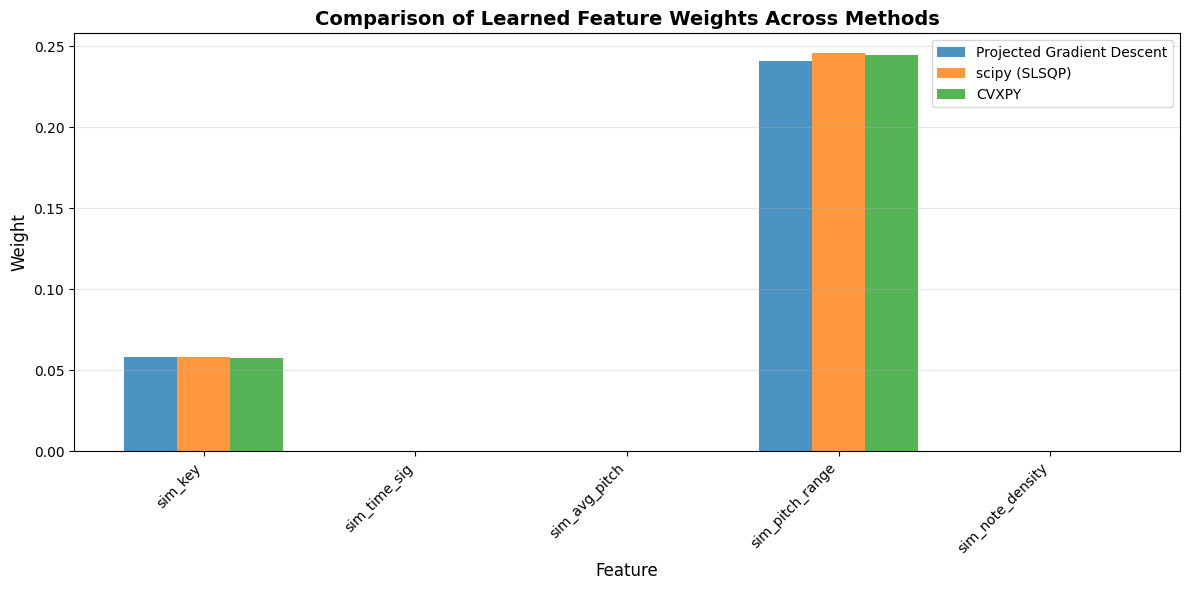

Interpretation:
The bar chart shows how each method weighs the different features.
Features with higher weights are considered more important for matching.


In [261]:
# Bar chart comparing learned weights
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(similarity_features))
width = 0.25

bars1 = ax.bar(x - width, pgd_weights, width, label='Projected Gradient Descent', alpha=0.8)
bars2 = ax.bar(x, scipy_weights, width, label='scipy (SLSQP)', alpha=0.8)
bars3 = ax.bar(x + width, cvxpy_weights, width, label='CVXPY', alpha=0.8)

ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.set_title('Comparison of Learned Feature Weights Across Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(similarity_features, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("The bar chart shows how each method weighs the different features.")
print("Features with higher weights are considered more important for matching.")

### Visualization: Loss Convergence

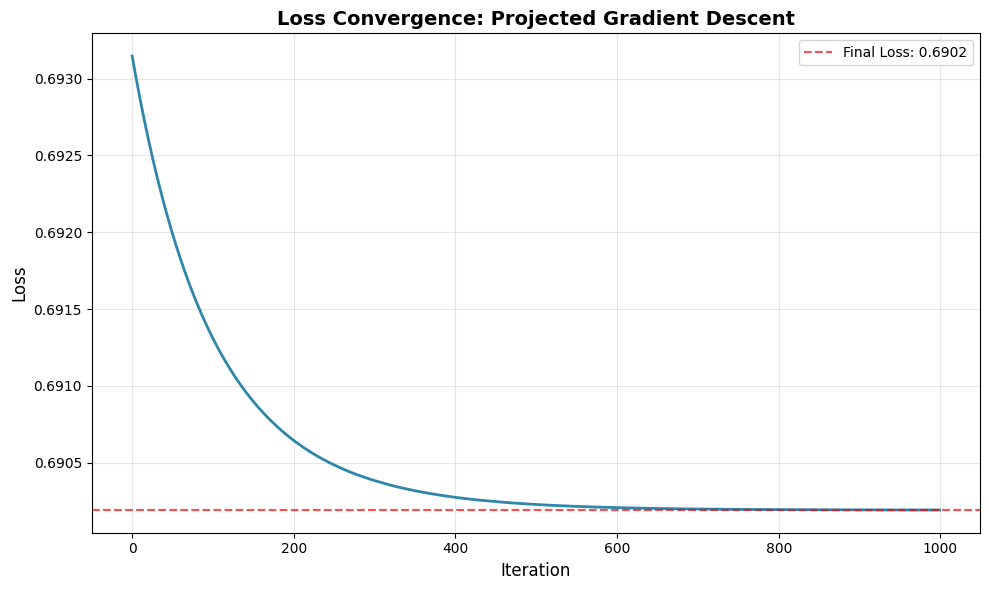

Loss decreased from 0.6931 to 0.6902
Reduction: 0.0030 (0.43%)


In [262]:
# Plot loss convergence for Projected Gradient Descent
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(len(pgd_results['hist']['L']))
ax.plot(iterations, pgd_results['hist']['L'], linewidth=2, color='#2E86AB')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Loss Convergence: Projected Gradient Descent', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add horizontal line for final loss
ax.axhline(y=pgd_loss, color='red', linestyle='--', alpha=0.7, label=f'Final Loss: {pgd_loss:.4f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Loss decreased from {pgd_results['hist']['L'][0]:.4f} to {pgd_loss:.4f}")
print(f"Reduction: {pgd_results['hist']['L'][0] - pgd_loss:.4f} ({(pgd_results['hist']['L'][0] - pgd_loss)/pgd_results['hist']['L'][0]*100:.2f}%)")

### Visualization: Accuracy Comparison

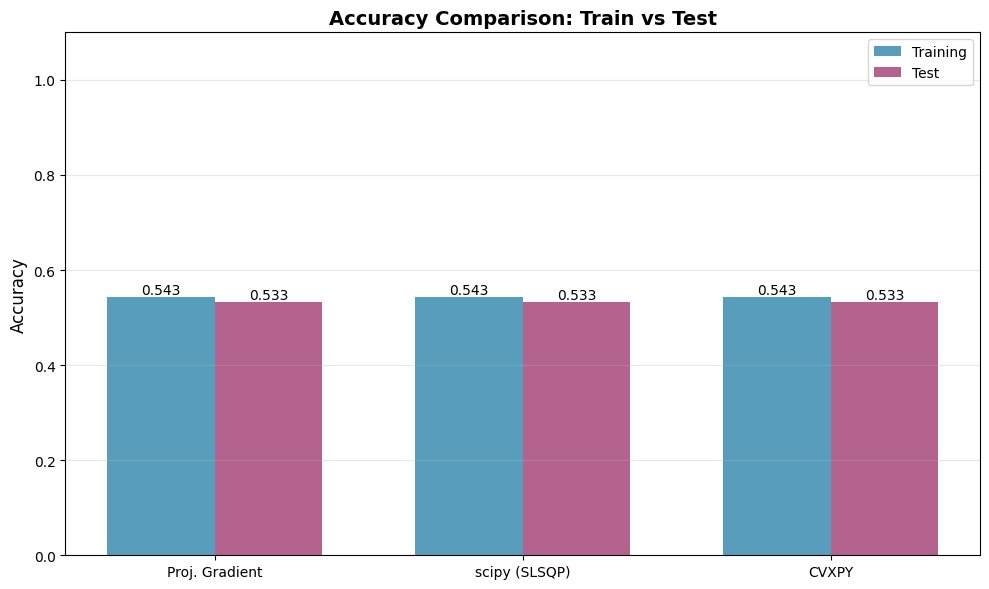

Observations:
  Best training accuracy: 0.5429
  Best test accuracy: 0.5333
  All methods achieve similar performance


In [263]:
# Grouped bar chart for accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Proj. Gradient', 'scipy (SLSQP)', 'CVXPY']
train_accuracies = [pgd_train_acc, scipy_train_acc, cvxpy_train_acc]
test_accuracies = [pgd_test_acc, scipy_test_acc, cvxpy_test_acc]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, train_accuracies, width, label='Training', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.8, color='#A23B72')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Comparison: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  Best training accuracy: {max(train_accuracies):.4f}")
print(f"  Best test accuracy: {max(test_accuracies):.4f}")
print(f"  All methods achieve similar performance")

In [264]:
# Use CVXPY weights as our "best" solution
best_weights = cvxpy_weights

# Compute predictions on test set
test_scores = X_test @ best_weights
test_predictions = (test_scores >= 0).astype(int)

# Calculate per-pair-type accuracies for summary
test_results_full = test_data.copy()
test_results_full['similarity_score'] = test_scores
test_results_full['prediction'] = test_predictions
test_results_full['correct'] = (test_predictions == y_test).astype(int)
matching_acc_test = test_results_full[test_results_full['pair_type'] == 'matching']['correct'].mean()
hard_neg_acc_test = test_results_full[test_results_full['pair_type'] == 'hard_negative']['correct'].mean()
easy_neg_acc_test = test_results_full[test_results_full['pair_type'] == 'easy_negative']['correct'].mean()

print("╔" + "="*78 + "╗")
print("║" + " "*78 + "║")
print("║" + "FINAL MODEL PERFORMANCE SUMMARY".center(78) + "║")
print("║" + " "*78 + "║")
print("╠" + "="*78 + "╣")
print("║" + " "*78 + "║")

# Best method
best_method = "CVXPY (Convex Optimization)"
print("║  " + f"Best Optimization Method: {best_method}".ljust(76) + "║")
print("║" + " "*78 + "║")

# Overall Accuracy
print("║  " + "OVERALL ACCURACY:".ljust(76) + "║")
print("║  " + f"  • Training: {cvxpy_train_acc:.4f} ({cvxpy_train_acc*100:.2f}%)".ljust(76) + "║")
print("║  " + f"  • Test:     {cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)".ljust(76) + "║")
print("║  " + f"  • Baseline: {initial_accuracy_test:.4f} ({initial_accuracy_test*100:.2f}%) [uniform weights]".ljust(76) + "║")
print("║  " + f"  • Improvement: +{(cvxpy_test_acc - initial_accuracy_test)*100:.2f} percentage points".ljust(76) + "║")
print("║" + " "*78 + "║")

# Per-Pair-Type Breakdown
print("║  " + "PERFORMANCE BY PAIR TYPE (Test Set):".ljust(76) + "║")
print("║  " + f"  • Matching pairs:      {matching_acc_test:.4f} ({matching_acc_test*100:.1f}%)".ljust(76) + "║")
print("║  " + f"  • Hard negatives:      {hard_neg_acc_test:.4f} ({hard_neg_acc_test*100:.1f}%)".ljust(76) + "║")
print("║  " + f"  • Easy negatives:      {easy_neg_acc_test:.4f} ({easy_neg_acc_test*100:.1f}%)".ljust(76) + "║")
print("║" + " "*78 + "║")

# Most important features
# Feature importance ranking
feature_importance = pd.DataFrame({
    'Feature': similarity_features,
    'Weight': best_weights,
    'Rank': range(1, 6)
})
top_2_features = feature_importance.head(2)
print("║  " + "MOST IMPORTANT FEATURES:".ljust(76) + "║")
for i, row in top_2_features.iterrows():
    print("║  " + f"  {row['Rank']}. {row['Feature']:20s} (weight={row['Weight']:.4f})".ljust(76) + "║")
print("║" + " "*78 + "║")

# Computation time
print("║  " + f"Training Time: {cvxpy_time:.4f} seconds".ljust(76) + "║")
print("║" + " "*78 + "║")

# Classification metrics
# Overall confusion matrix
cm = confusion_matrix(y_test, test_predictions)
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print("║  " + "OVERALL CLASSIFICATION METRICS:".ljust(76) + "║")
print("║  " + f"  • Precision: {precision:.4f}".ljust(76) + "║")
print("║  " + f"  • Recall:    {recall:.4f}".ljust(76) + "║")
print("║  " + f"  • F1-Score:  {f1:.4f}".ljust(76) + "║")
print("║" + " "*78 + "║")

print("╚" + "="*78 + "╝")
print()

# Add discussion box
print("╔" + "="*78 + "╗")
print("║" + " "*78 + "║")
print("║" + "KEY INSIGHTS: Multi-Composer Performance".center(78) + "║")
print("║" + " "*78 + "║")
print("╠" + "="*78 + "╣")
print("║" + " "*78 + "║")
print("║  " + f"The model achieves {matching_acc_test*100:.1f}% accuracy on matching pairs but only".ljust(76) + "║")
print("║  " + f"{hard_neg_acc_test*100:.1f}% on hard negatives, suggesting that distinguishing pieces by".ljust(76) + "║")
print("║  " + "the same composer is more challenging than identifying matching pages.".ljust(76) + "║")
print("║" + " "*78 + "║")
print("║  " + f"Easy negatives (different composers) achieve {easy_neg_acc_test*100:.1f}% accuracy,".ljust(76) + "║")
print("║  " + "confirming that composer-level differences are effectively captured by".ljust(76) + "║")
print("║  " + "the learned feature weights.".ljust(76) + "║")
print("║" + " "*78 + "║")
if matching_acc_test > hard_neg_acc_test:
    diff = (matching_acc_test - hard_neg_acc_test) * 100
    print("║  " + f"The {diff:.1f} percentage point gap between matching pairs and hard".ljust(76) + "║")
    print("║  " + "negatives indicates that same-composer pieces share similar musical".ljust(76) + "║")
    print("║  " + "characteristics, making within-composer discrimination the hardest task.".ljust(76) + "║")
print("║" + " "*78 + "║")
print("╚" + "="*78 + "╝")

╔==============================================================================╗
║                                                                              ║
║                       FINAL MODEL PERFORMANCE SUMMARY                        ║
║                                                                              ║
╠==============================================================================╣
║                                                                              ║
║  Best Optimization Method: CVXPY (Convex Optimization)                       ║
║                                                                              ║
║  OVERALL ACCURACY:                                                           ║
║    • Training: 0.5429 (54.29%)                                               ║
║    • Test:     0.5333 (53.33%)                                               ║
║    • Baseline: 0.4000 (40.00%) [uniform weights]                             ║
║    • Improvement: +13.33 p